# A simple MZ-RT annotation script

THis notebook perform a simple RT annotation of a set of features (From a datamatrix) using a list of candidates (from a table with InChi and ID) from a table aswell as a list of reference features containing at least the structure and a retention time (InChi and RT). The script will then perofrm the follwoing step sequentially:
 * Compute an RT prediction model using the references
 * Compute the set of possible mass given the mass in the data
 * Compute the best possible annotation using maximum matching and ht epredicted properties
 The output will be givne as a datatable which will rank the different candidat aswell as giving a main annotation.

## Prerequisite 

We first just load the required packages (There is a bunch)

In [12]:
from rdkit.Chem import MolFromInchi
from rdkit.Chem.Descriptors import ExactMolWt,descList
from rdkit.ML.Descriptors import MoleculeDescriptors
from networkx import max_weight_matching,Graph,isolates
from networkx.algorithms.bipartite.matching import minimum_weight_full_matching
from sklearn.model_selection import cross_val_score
from scipy.stats import norm
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we just define some constant which will be used to process the data:

In [73]:
TEST = True
FINAL_OUTPUT_PATH = "path to output"
FEAT_PATH = "path to features.csv"
CAND_PATH = "path to candidates.csv"
REF_PATH = "path to references.csv"

#Feature table
FEAT_MZ_COL = "mz"
FEAT_RT_COL = "rt"
FEAT_DELIMITER = "\t"

# Candidates table
CAND_INCHI_COL = "inchi"
CAND_NAME_COL = "kegg_id"
CAND_SUPP = ["name","inchi"]
CAND_DELIMITER = ";"

# Reference table
REF_INCHI_COL = "inchi"
REF_RT_COL = "rt"
REF_DELIMITER = ";"

if TEST:
    FINAL_OUTPUT_PATH = "/home/dalexis/Documents/test_output_annot_script.csv"
    REF_PATH = "/home/dalexis/Documents/data/metDNA_datasets/Dataset 1/spiked_with_inchi2.csv"
    REF_RT_COL = "RT..s."
    REF_DELIMITER = ","
    CAND_PATH = "/home/dalexis/Documents/data/databases/kegg/kegg.csv"
    CAND_INCHI_COL = "inchi"
    CAND_NAME_COL = "kegg_id"
    FEAT_PATH = "/home/dalexis/Documents/data/metDNA_datasets/Dataset 1/POS/data.csv"
    FEAT_MZ_COL = "mz"
    FEAT_RT_COL = "rt"
    FEAT_DELIMITER = ","
    

__This part incorporate the tolerance of the annotation. It should eb changed dependeing of your experiment:__

In [14]:
# This can be in minutes or seconds depending of the unit of your feature or reference table
# If it is None it will be set to 2 times the erro of the model
ACCURACY_RT = 30
ACCURACY_MZ = 0.007# This is the target accuracy MZ
CUTOFF_MZ_DA = 0.01 #THis is a strict cut-off used ot collect candidates it should logically be high than accuracy mz
CUTOFF_MZ_PPM = 15

We now load all the table

In [15]:
refs = pd.read_csv(REF_PATH,delimiter = REF_DELIMITER)
candidates = pd.read_csv(CAND_PATH,delimiter = CAND_DELIMITER)
features = pd.read_csv(FEAT_PATH,delimiter = FEAT_DELIMITER)

## RT prediction 

This part predict RT using the references. We start by computing the descriptor

In [58]:
# We parse the references molecules
mols = [MolFromInchi(inchi) for inchi in refs[REF_INCHI_COL]]

# descList is a list of pair name,function where name is a descriptor
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator([dd[0] for dd in descList])

def compute_descriptors(mol):
    return descriptor_calculator.CalcDescriptors(mol)

descriptors = [compute_descriptors(mol) for mol in mols]
X = np.vstack(descriptors)
Y = np.array(refs[REF_RT_COL].tolist())
print(X.shape)
#At this point we have the descriptors, we stack them for easier processind


(200, 208)


We then remove the columns with constant and missing values:

In [59]:
#Dropping the nan
df = pd.concat([pd.DataFrame(Y),pd.DataFrame(X)],axis=1)
df = df.dropna()
Y = df.iloc[:,0]
X = df.iloc[:,1:]

#Remove the constant elements
sel_descriptors = (X != X.iloc[0]).any()
X = X.loc[:, sel_descriptors] 


The resulting table has dim:  

In [60]:
print(X.shape)

(200, 167)


We can then fit a simple xgboost model:

In [69]:
xgbm = xgb.XGBRegressor(booster="gblinear",n_estimators=50,learning_rate=0.05)
vscore = cross_val_score(xgbm,X.to_numpy(),Y,cv=5)

The mean prediction score is then compared to the data in

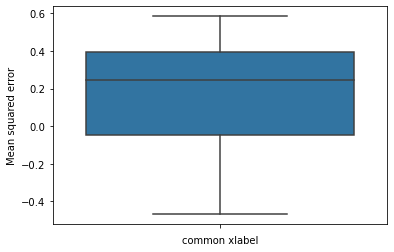

In [70]:
ax = sns.boxplot(y=vscore)
ax = ax.set(xlabel='common xlabel', ylabel="Mean squared error")

We then do the do the ful prediction:

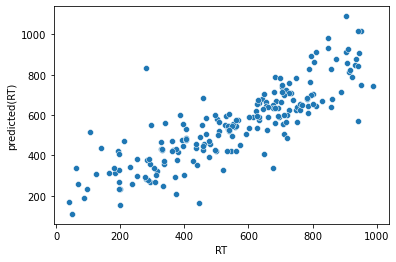

In [71]:
xgbm = xgbm.fit(X.to_numpy(),Y)
ax = sns.scatterplot(x=Y,y=xgbm.predict(X.to_numpy()))
ax = ax.set(xlabel='RT', ylabel="predicted(RT)")

We can now predict RT for all the candidates (This step can be time consuming. If you use it many times you can consider cahing the descriptors)

In [22]:
mols = [MolFromInchi(inchi) for inchi in candidates[CAND_INCHI_COL]]
#We remove the invalid inchi
valid_candidates = [idx for idx,mol in enumerate(mols) if mol is not None]
descriptors = [compute_descriptors(mols[idx]) for idx in valid_candidates]
X = np.vstack(descriptors)

RDKit ERROR: [14:39:07] ERROR: Explicit valence for atom # 10 S, 8, is greater than permitted
RDKit ERROR: [14:40:02] Explicit valence for atom # 10 S, 8, is greater than permitted


In [23]:
pred_RT = xgbm.predict(X[:,sel_descriptors])
# We also compute the thoeritical mass of the candidates
pred_mass = [ExactMolWt(mols[idx]) for idx in valid_candidates] 


## Doing the matching

Using the predicted RT and the computed mass we first find the candidates to do se we first have to compute the adduct mass.

In [24]:
adducts = [("+H",1.00728),("+Na",22.9897)]
all_candidates_masses = np.array([mass+add_mass for mass in pred_mass for ass,add_mass in adducts])


We then do the mass matching using a ppn and dmz tolerance.

In [25]:
def match_mz(x,y,ppm=10,dmz=0.01,single_match=False):
    ox = np.argsort(x)
    oy = np.argsort(y)
    ty = y[oy]
    x_max_ppm = x[ox]+(ppm*x[ox]*1e-6)
    x_max_dmz = x[ox]+dmz
    x_max = np.maximum(x_max_ppm,x_max_dmz)
    x_min_ppm = x[ox]-(ppm*x[ox]*1e-6)
    x_min_dmz = x[ox]-dmz
    x_min = np.minimum(x_min_ppm,x_min_dmz)
    lb = np.searchsorted(ty,x_min)
    ub = np.searchsorted(ty,x_max)

    size_matches = ub-lb
    res = [None] * ox.shape[0]
    for idx in range(len(res)):
        if size_matches[idx]==0: continue
        val_idx = oy[lb[idx]:ub[idx]]
        res[ox[idx]]=list(val_idx)

    return res

feat_mz = features[FEAT_MZ_COL].to_numpy()
feat_rt = features[FEAT_RT_COL].to_numpy()
vmatch = match_mz(feat_mz,all_candidates_masses)

To distinguish between the different candidates we build a graph and perform a maximal matching.The goodness of a match is detemrined by modelling agaussiuan error across the rest of this shit.

In [26]:
nfeatures = features.shape[0]
ncandidates = len(all_candidates_masses)

##Initalizing the graph
G = Graph()
G.add_nodes_from(range(nfeatures),bipartite=0)
G.add_nodes_from(range(nfeatures,nfeatures+ncandidates),bipartite=1)


# This is the function for the socring
def dist_mz(x):
    return norm.pdf(x,loc=0,scale=ACCURACY_MZ)
def dist_rt(x):
    return norm.pdf(x,loc=0,scale=ACCURACY_RT)

def make_edge_weight(fmz,frt,tmz,trt):
    return(1-dist_mz(fmz-tmz)*dist_rt(frt-trt))

#We add the edges of the graph
all_edges = []
epsilon= 1e-7
for ifeat,fmatch in enumerate(vmatch):
    if fmatch is None:
        continue
    current_edges = []
    for fcand in vmatch[ifeat]:
        cand_no_adduct = fcand//2
        #SOrry for this ugly line
        weight = make_edge_weight(feat_mz[ifeat],feat_rt[ifeat],all_candidates_masses[fcand],pred_RT[cand_no_adduct])
        if weight<=epsilon:
            continue
        current_edges.append((ifeat,fcand+nfeatures,{"weight":weight}))
    all_edges.append(current_edges)
    
all_edges = [y for x in all_edges for y in x]
G.add_edges_from(all_edges)
G.remove_nodes_from(list(isolates(G)))

We can check the number of candidates by features:

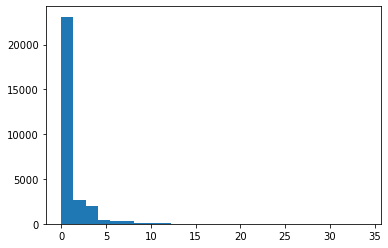

In [27]:
ax = plt.hist([len(G[x]) for x in G],bins=25)
# THIs is dome debug code that I leave because there is a high chance that I need it at some point
# if False:
#     debug_idx = 100
#     VEDGE = all_edges[debug_idx]
#     print(VEDGE)
#     print("fmz:",feat_mz[VEDGE[0]])
#     print("frt:",feat_rt[VEDGE[0]])
#     print("tmz:",all_candidates_masses[VEDGE[1]-nfeatures])
#     print("trt:",pred_RT[(VEDGE[1]-nfeatures)//2])


This step is potentially time consuming, normally not too much except if you have a lot of features.

In [33]:
## I would love to do a maxmatching but the networkx algorithm is badly implemented and crashes. I have ot recode it at some point
if False:
    val_match = minimum_weight_full_matching(G,weight='weight',top_nodes=list(range(nfeatures)))
else:
    val_match = [None]*nfeatures
    for fidx in range(nfeatures):
        if fidx not in G or len(G[fidx])==0: continue
        val_match[fidx] = (min([x for x in G[fidx]],key=lambda x: G[fidx][x]["weight"]),[x for x in G[fidx]])
        

We now just have to build the output.

## Output Building 

We just build exactly the same table but add each matching in the table.

In [74]:
main_annot = [None]*nfeatures
all_annot = [None]*nfeatures
score = [None]*nfeatures
supp_col = []
supp_col_all = []
for _ in CAND_SUPP:
    supp_col.append([None]*nfeatures)
    supp_col_all.append([None]*nfeatures)
for fidx in range(nfeatures):
    if val_match[fidx] is None:
        continue
    else:
        main_cand = valid_candidates[(val_match[fidx][0]-nfeatures)//2]
        supp_cands = [valid_candidates[(x - nfeatures)//2] for x in val_match[fidx][1]]
        main_annot[fidx] = candidates[CAND_NAME_COL].iloc[main_cand]
        all_annot[fidx] = "|".join([candidates[CAND_NAME_COL].iloc[cc] for cc in supp_cands])
        for sidx in range(len(CAND_SUPP)):
            supp_col[sidx][fidx] = candidates[CAND_SUPP[sidx]].iloc[main_cand]
            supp_col_all[sidx][fidx] = "|".join([candidates[CAND_SUPP[sidx]].iloc[cc] for cc in supp_cands])
    
#We now build the final table
final_table = features.copy()
final_table["main_annotation"] = main_annot
final_table["all_candidates"] = all_annot
for sidx in range(len(CAND_SUPP)):
    final_table["main_annotation_"+CAND_SUPP[sidx]] = supp_col[sidx]
    final_table["all_candidates_"+CAND_SUPP[sidx]] = supp_col_all[sidx]


We just have to export the annotation

In [77]:
 final_table.to_csv(FINAL_OUTPUT_PATH,index=False)
FINAL_OUTPUT_PATH

'/home/dalexis/Documents/test_output_annot_script.csv'